<a href="https://colab.research.google.com/github/abdulrahman-hassanin/COVID19-Detection-CT-scans/blob/master/COVID_19_Lung_CT_Scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"abdulrahmanhassanin","key":"e78be1d7021f152e76aeb722d383ed56"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [3]:
!kaggle datasets download -d luisblanche/covidct

covidct.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
%cd /content
%ls

/content
 covidct.zip   graph4_94.jpg      model2.h5              model.h5
 Dataset/      graph4_97.jpg      model3.h5              my_model.h5
 graoh.jpg     graph4.jpg         model4_97.h5           sample_data/
 graph2.jpg   'kaggle (1).json'   model4_97_weights.h5
 graph3.jpg    kaggle.json        model4.h5


In [5]:
!mkdir /content/Dataset/

mkdir: cannot create directory ‘/content/Dataset/’: File exists


In [6]:
!unzip -q covidct.zip -d /content/Dataset

replace /content/Dataset/COVID-CT-MetaInfo.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
import random
import shutil

In [8]:
!mkdir /content/Dataset/train
!mkdir /content/Dataset/test

mkdir: cannot create directory ‘/content/Dataset/train’: File exists
mkdir: cannot create directory ‘/content/Dataset/test’: File exists


In [9]:
%cd /content/Dataset
!ls

/content/Dataset
COVID-CT-MetaInfo.xlsx	CT_COVID  CT_NonCOVID  test  train


In [0]:
data_root='/content/Dataset'
path_covid = os.path.join(data_root, 'CT_COVID/')
path_NonCovid = os.path.join(data_root, 'CT_NonCOVID/')

In [0]:
# jpg and png files
covid_images_ls = glob(os.path.join(path_covid,"*.png"))

nonCovid_images_ls = glob(os.path.join(path_NonCovid,"*.png"))
nonCovid_images_ls.extend(glob(os.path.join(path_NonCovid,"*.jpg")))

In [0]:
covid = {'class': 'CT_COVID',
         'path': path_covid,
         'images': covid_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_NonCovid,
             'images': nonCovid_images_ls}

In [13]:
total_covid = len(covid_images_ls)
total_nonCovid = len(nonCovid_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_covid))
print("Total Negative Cases Covid19 images: {}".format(total_nonCovid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


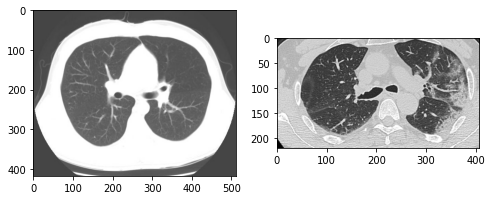

In [14]:
image_covid = cv2.imread(os.path.join(covid_images_ls[1]))
image_nonCovid = cv2.imread(os.path.join(nonCovid_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_nonCovid)
f.add_subplot(1,2, 2)
plt.imshow(image_covid)

In [15]:
print("Image COVID Shape {}".format(image_covid.shape))
print("Image Non COVID Shape {}".format(image_nonCovid.shape))

Image COVID Shape (221, 408, 3)
Image Non COVID Shape (418, 512, 3)


In [0]:
subdirs  = ['/content/Dataset/train/', '/content/Dataset/test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [17]:
%cd /content/Dataset/train/
!ls

/content/Dataset/train
CT_COVID  CT_NonCOVID


In [18]:
# Copy Images to test set
random.seed(0)
# data_splitting 
test_ratio = 0.25


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, '/content/Dataset/test/' + cases['class'])

CT_COVID 87
CT_NonCOVID 99


In [0]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('/content/Dataset/test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, '/content/Dataset/train/' + cases['class'])

In [20]:
train_data_path = '/content/Dataset/train'
test_data_path  = '/content/Dataset/test'
total_train_covid    = len(os.listdir(os.path.join(train_data_path, 'CT_COVID/')))
total_train_noncovid = len(os.listdir(os.path.join(train_data_path, 'CT_NonCOVID/')))
total_test_covid     = len(os.listdir(os.path.join(test_data_path, 'CT_COVID/')))
total_test_noncovid  = len(os.listdir(os.path.join(test_data_path, 'CT_NonCOVID/')))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 315
Train sets images Non COVID: 358
Test sets images COVID: 88
Test sets images Non COVID: 121


In [21]:
%cd /content/

/content


# Data Prepocessing 

In [22]:
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


In [0]:
IMG_HEIGHT = 200
IMG_WIDTH = 200
# batch_size = 214
epochs = 75
num_classes = 1

total_train = total_train_covid + total_train_noncovid
total_test  = total_test_covid  + total_test_noncovid

In [0]:
Image_generator = ImageDataGenerator(rescale=1./255) # Generator data

In [25]:
train_data = Image_generator.flow_from_directory(batch_size=total_train,
                                                     directory=train_data_path,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=['CT_NonCOVID', 'CT_COVID'],
                                                     class_mode='binary')

Found 673 images belonging to 2 classes.


In [26]:
test_data = Image_generator.flow_from_directory(batch_size=total_test,
                                                    directory=test_data_path,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes=['CT_NonCOVID', 'CT_COVID'],
                                                    class_mode='binary')

Found 209 images belonging to 2 classes.


In [0]:
# Extract Data
for X_train, y_train in train_data:
    break
for X_test, y_test in test_data:
    break

In [28]:
# classes Label
train_data.class_indices

{'CT_COVID': 1, 'CT_NonCOVID': 0}

# Training 

In [0]:
model = Sequential([
    Conv2D(8, (3,3), activation='relu', padding='same' ,input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]),  
    MaxPooling2D(2),
    
    Conv2D(32, (3,3), padding='same' ,activation='relu'),   
    MaxPooling2D(2),  
    Dropout(0.5),    
    
    Conv2D(64, (3,3), padding='same' ,activation='relu'),
    MaxPooling2D(2),    
    Dropout(0.5),
    
    Conv2D(132, (3,3), padding='same' ,activation='relu'),  
    MaxPooling2D(2),  
    Dropout(0.5),   #0.8
      
    
    Flatten(),    
    Dense(512, activation='relu'),
    Dropout(0.5),     #0.8

    Dense(64, activation='relu'),
    Dropout(0.5),
     
    Dense(num_classes, activation='sigmoid') 
])

In [0]:
# compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [106]:
# early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
early = EarlyStopping(
        monitor='val_acc', 
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1)
check_point = ModelCheckpoint("./my_model.h5", monitor="val_loss", save_best_only=True)

callbacks_list = [ check_point, early]


history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=150,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list
)

Train on 673 samples, validate on 209 samples
Epoch 1/150
673/673 [==============================] - 1s 2ms/step - loss: 0.7546 - acc: 0.5171 - val_loss: 0.6919 - val_acc: 0.5789
Epoch 2/150
673/673 [==============================] - 1s 1ms/step - loss: 0.6941 - acc: 0.5319 - val_loss: 0.6898 - val_acc: 0.5789
Epoch 3/150
673/673 [==============================] - 1s 1ms/step - loss: 0.6916 - acc: 0.5334 - val_loss: 0.6893 - val_acc: 0.5789
Epoch 4/150
673/673 [==============================] - 1s 1ms/step - loss: 0.6876 - acc: 0.5602 - val_loss: 0.6869 - val_acc: 0.6411
Epoch 5/150
673/673 [==============================] - 1s 1ms/step - loss: 0.6848 - acc: 0.5721 - val_loss: 0.6778 - val_acc: 0.6411
Epoch 6/150
673/673 [==============================] - 1s 1ms/step - loss: 0.6589 - acc: 0.6181 - val_loss: 0.6637 - val_acc: 0.6699
Epoch 7/150
673/673 [==============================] - 1s 1ms/step - loss: 0.6396 - acc: 0.6746 - val_loss: 0.6438 - val_acc: 0.6459
Epoch 8/150
673/673 [==

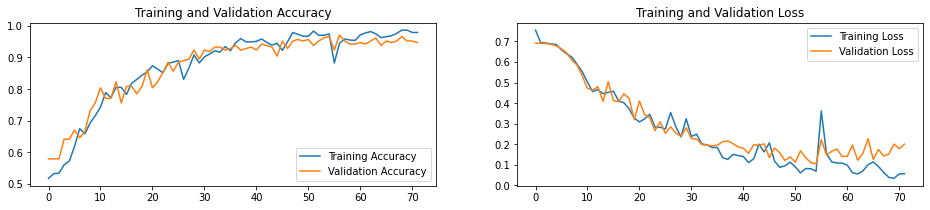

In [111]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('graph4_97_final.jpg')
plt.show()

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [109]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

y_pred = model.predict(X_test)
recall = recall_m(y_test, y_pred)
precision = precision_m(y_test, y_pred)
f1_score = f1_m(y_test, y_pred)

print("loss = ", loss)
print("accuracy = ", accuracy)
print("f1_score = ", f1_score.numpy())
print("precision = ", precision.numpy())
print("recall = ", recall.numpy())

loss =  0.14851313506801161
accuracy =  0.9712918400764465
f1_score =  90.9011
precision =  88.0
recall =  94.0


In [0]:
model.save("model_97_final.h5")

In [112]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 200, 200, 8)       224       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 100, 100, 32)      2336      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 25, 25, 64)      